In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import findspark
findspark.init()

In [3]:
%load_ext autoreload
%autoreload 2
from pyspark.sql import DataFrame
from utils.utilities import read_file,write_output

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder. \
    appName("Data-Processing"). \
    getOrCreate()
spark.conf.set("spark.debug.maxToStringFields", 100000)
spark.conf.set("spark.sql.debug.maxToStringFields", 100000)

## Variables

In [5]:
input_path="/dataset/nyc-jobs.csv"
output_path="file:///dataset/output/"

### Read data

In [7]:
df=read_file(input_path)

# Data Processing
### 1. Create functions to process your dataset (Cleaning, column pre-processing, data wrangling, transformation etc)
### 2. Apply atleast 3 feature engineering techniques
### 3. Features removal based on the exploration/ profiling.
### 4. Store your processed data into a target file

## 1. Functions to process dataset (Cleaning, column pre-processing, data wrangling, transformation etc)

#### A. Clean Column Names

In [70]:
print("-----------------------------------------------------------------------------------------")
print(f"Column Names before Cleanup are {df.columns}")
print("-----------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------
Column Names before Cleanup are ['Job ID', 'Agency', 'Posting Type', '# Of Positions', 'Business Title', 'Civil Service Title', 'Title Code No', 'Level', 'Job Category', 'Full-Time/Part-Time indicator', 'Salary Range From', 'Salary Range To', 'Salary Frequency', 'Work Location', 'Division/Work Unit', 'Job Description', 'Minimum Qual Requirements', 'Preferred Skills', 'Additional Information', 'To Apply', 'Hours/Shift', 'Work Location 1', 'Recruitment Contact', 'Residency Requirement', 'Posting Date', 'Post Until', 'Posting Updated', 'Process Date']
-----------------------------------------------------------------------------------------


In [71]:
from utils.utilities import clean_columns

In [72]:
df=clean_columns(df)

In [73]:
print("-----------------------------------------------------------------------------------------")
print(f"Column Names After Cleanup are {df.columns}")
print("-----------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------
Column Names After Cleanup are ['job_id', 'agency', 'posting_type', 'no_of_positions', 'business_title', 'civil_service_title', 'title_code_no', 'level', 'job_category', 'full-time/part-time_indicator', 'salary_range_from', 'salary_range_to', 'salary_frequency', 'work_location', 'division/work_unit', 'job_description', 'minimum_qual_requirements', 'preferred_skills', 'additional_information', 'to_apply', 'hours/shift', 'work_location_1', 'recruitment_contact', 'residency_requirement', 'posting_date', 'post_until', 'posting_updated', 'process_date']
-----------------------------------------------------------------------------------------


#### B. Remove Duplicates

In [74]:
from utils.utilities import remove_duplicates

In [75]:
print("-----------------------------------------------------------------------------------------")
print(f"Count Before Removing Duplicates is {df.count()}")
print("-----------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------
Count Before Removing Duplicates is 2946
-----------------------------------------------------------------------------------------


In [76]:
df=remove_duplicates(df)

In [77]:
print("-----------------------------------------------------------------------------------------")
print(f"Count After Removing Duplicates is {df.count()}")
print("-----------------------------------------------------------------------------------------")

-----------------------------------------------------------------------------------------
Count After Removing Duplicates is 2915
-----------------------------------------------------------------------------------------


#### C. Clean String Column's

In [78]:
from utils.utilities import clean_str_cols

In [79]:
str_columns=['civil_service_title','job_description','minimum_qual_requirements','preferred_skills','additional_information','to_apply','hours/shift']


In [80]:
print(f"String Column Before Cleanup is : {df.select('preferred_skills').show(10,False)}")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [81]:
df=clean_str_cols(df,str_columns)

In [82]:
print(f"String Column After Cleanup is : {df.select('preferred_skills').show(10,False)}")

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### D. Transformation's

##### Derive How Long back[Years] Job was posted
##### What was Job Posting Year

In [83]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f
df.withColumn("current_date",current_date()).\
withColumn("post_date",to_date(col('posting_date'),'yyyy-MM-dd')).\
withColumn("posting_year",year(col("post_date"))).\
withColumn("years_old_job",round(months_between(current_date(),col("post_date"))/lit(12),2)).drop('post_date').\
select('job_id','posting_date','years_old_job','posting_year').show(5)

+------+-------------------+-------------+------------+
|job_id|       posting_date|years_old_job|posting_year|
+------+-------------------+-------------+------------+
|306957|2017-09-27 00:00:00|         4.92|        2017|
|355745|2018-08-08 00:00:00|         4.05|        2018|
|376556|2018-12-10 00:00:00|         3.72|        2018|
|160910|2014-08-21 00:00:00|         8.02|        2014|
|234921|2016-03-11 00:00:00|         6.46|        2016|
+------+-------------------+-------------+------------+
only showing top 5 rows



## 2. Apply atleast 3 feature engineering techniques

### A. Imputation

In [135]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- no_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full-time/part-time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division/work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- hours/shift: string (nullable = true)
 |-- work_loca

In [84]:
df=df.na.drop(how="all")
df=df.drop('recruitment_contact')

In [85]:
nullCols=['job_category','full-time/part-time_indicator','preferred_skills','additional_information',
              'to_apply','hours/shift','work_location_1','residency_requirement','post_until','posting_updated',
              'process_date']

In [86]:
df=df.na.fill('NA values', nullCols)

In [87]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- no_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = false)
 |-- full-time/part-time_indicator: string (nullable = false)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division/work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = false)
 |-- additional_information: string (nullable = false)
 |-- to_apply: string (nullable = false)
 |-- hours/shift: string (nullable = false)
 |-- wor

### A. Create new column from existing column

In [90]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f

def feat_from_date(df:DataFrame) -> DataFrame:
    """
    """
    df=df.withColumn("current_date",current_date()).\
    withColumn("post_date",to_date(col('posting_date'),'yyyy-MM-dd')).\
    withColumn("posting_year",year(col("post_date"))).\
    withColumn("years_old_job",round(months_between(current_date(),col("post_date"))/lit(12),2)).drop('post_date')
    return df

In [91]:
df=feat_from_date(df)

In [92]:
df.select('job_id','posting_date','years_old_job','posting_year').show(5,False)

+------+-------------------+-------------+------------+
|job_id|posting_date       |years_old_job|posting_year|
+------+-------------------+-------------+------------+
|306957|2017-09-27 00:00:00|4.92         |2017        |
|355745|2018-08-08 00:00:00|4.05         |2018        |
|376556|2018-12-10 00:00:00|3.72         |2018        |
|160910|2014-08-21 00:00:00|8.02         |2014        |
|234921|2016-03-11 00:00:00|6.46         |2016        |
+------+-------------------+-------------+------------+
only showing top 5 rows



 ###  B. Handling Outliers

In [93]:
numerical_columns=["no_of_positions","salary_range_from","salary_range_to"]

In [94]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- no_of_positions: integer (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = false)
 |-- full-time/part-time_indicator: string (nullable = false)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division/work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = false)
 |-- additional_information: string (nullable = false)
 |-- to_apply: string (nullable = false)
 |-- hours/shift: string (nullable = false)
 |-- wor

In [96]:
pdf=df.toPandas()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='salary_range_from'>

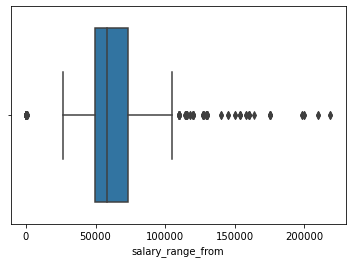

In [24]:
# Box Plot
import seaborn as sns
sns.boxplot(pdf['salary_range_from'])

In [25]:
import numpy as np
print(np.where(pdf['salary_range_from']>100000))

(array([  90,  234,  265,  289,  311,  320,  340,  351,  439,  471,  550,
        563,  619,  645,  654,  664,  669,  679,  685,  687,  713,  715,
        729,  734,  938,  944, 1022, 1038, 1059, 1062, 1071, 1076, 1133,
       1238, 1272, 1311, 1355, 1362, 1370, 1371, 1372, 1381, 1386, 1387,
       1400, 1423, 1465, 1493, 1537, 1588, 1622, 1646, 1659, 1674, 1699,
       1705, 1706, 1720, 1725, 1749, 1754, 1768, 1770, 1783, 1792, 1823,
       1862, 1908, 1926, 1953, 1972, 2052, 2074, 2081, 2088, 2101, 2114,
       2134, 2235, 2237, 2303, 2387, 2421, 2440, 2454, 2465, 2477, 2480,
       2527, 2540, 2563, 2606, 2621, 2627, 2631, 2638, 2658, 2669, 2682,
       2718, 2769, 2803, 2808, 2842, 2869, 2876, 2880, 2899]),)


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='salary_range_to'>

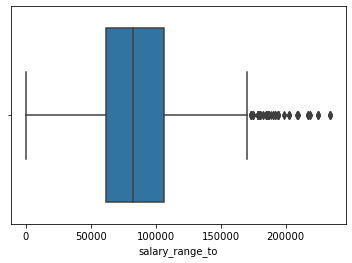

In [26]:
# Box Plot
import seaborn as sns
sns.boxplot(pdf['salary_range_to'])

In [31]:
import numpy as np
print(np.where(pdf['salary_range_to']>175000))

(array([  15,   21,   23,   39,   55,   61,   74,   88,   90,   94,   97,
         99,  125,  144,  184,  234,  237,  370,  396,  419,  424,  439,
        456,  514,  521,  563,  729,  801,  826,  837,  849,  857,  911,
        938,  981, 1035, 1112, 1119, 1149, 1170, 1209, 1216, 1235, 1251,
       1291, 1357, 1414, 1426, 1465, 1493, 1564, 1586, 1588, 1618, 1622,
       1646, 1649, 1672, 1705, 1723, 1725, 1734, 1795, 1842, 1852, 1862,
       1878, 1879, 1883, 1894, 1910, 1917, 1918, 1945, 1953, 2075, 2188,
       2189, 2192, 2214, 2235, 2250, 2252, 2268, 2312, 2387, 2403, 2438,
       2540, 2549, 2550, 2563, 2599, 2606, 2621, 2627, 2663, 2669, 2707,
       2718, 2804, 2818, 2832, 2886]),)


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='no_of_positions'>

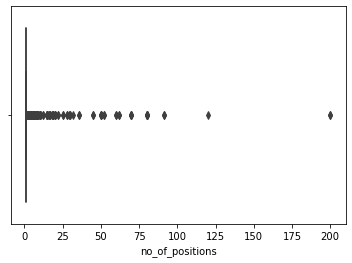

In [33]:
# Box Plot
import seaborn as sns
sns.boxplot(pdf['no_of_positions'])

In [97]:
''' Detection '''
# IQR
Q1 = np.percentile(pdf['salary_range_from'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(pdf['salary_range_from'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", pdf.shape)
 
# Upper bound
upper = np.where(pdf['salary_range_from'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(pdf['salary_range_from'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
pdf.drop(upper[0], inplace = True)
pdf.drop(lower[0], inplace = True)
 
print("New Shape: ", pdf.shape)

Old Shape:  (2915, 30)
New Shape:  (2584, 30)


In [98]:
df=spark.createDataFrame(pdf)

### C. One-Hot Encoding

In [99]:
df.columns

['job_id',
 'agency',
 'posting_type',
 'no_of_positions',
 'business_title',
 'civil_service_title',
 'title_code_no',
 'level',
 'job_category',
 'full-time/part-time_indicator',
 'salary_range_from',
 'salary_range_to',
 'salary_frequency',
 'work_location',
 'division/work_unit',
 'job_description',
 'minimum_qual_requirements',
 'preferred_skills',
 'additional_information',
 'to_apply',
 'hours/shift',
 'work_location_1',
 'residency_requirement',
 'posting_date',
 'post_until',
 'posting_updated',
 'process_date',
 'current_date',
 'posting_year',
 'years_old_job']

In [100]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='posting_type', outputCol='posting_type_numeric')
df_indexed = indexer.fit(df).transform(df)
# df_indexed.show()

22/08/28 11:55:10 WARN TaskSetManager: Stage 114 contains a task of very large size (1712 KiB). The maximum recommended task size is 1000 KiB.


In [101]:
df_indexed.select('posting_type','posting_type_numeric').show()

22/08/28 11:55:15 WARN TaskSetManager: Stage 117 contains a task of very large size (1712 KiB). The maximum recommended task size is 1000 KiB.
+------------+--------------------+
|posting_type|posting_type_numeric|
+------------+--------------------+
|    External|                 1.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    External|                 1.0|
|    Internal|                 0.0|
|    External|                 1.0|
|    External|                 1.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    External|                 1.0|
|    Internal|                 0.0|
|    External|                 1.0|
|    External|                 1.0|
|    Internal|                 0.0|
|    Internal|                 0.0|
|    External|                 1.0|
+------------+---------------

In [102]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol="posting_type_numeric", outputCol="posting_type_onehot")
encoder.setDropLast(False)
ohe = encoder.fit(df_indexed) # indexer is the existing dataframe, see the question
indexer = ohe.transform(df_indexed)

In [57]:
indexer.select('job_id','posting_type_numeric','posting_type_onehot').show()

+------+--------------------+-------------------+
|job_id|posting_type_numeric|posting_type_onehot|
+------+--------------------+-------------------+
|306957|                 1.0|      (2,[1],[1.0])|
|355745|                 0.0|      (2,[0],[1.0])|
|376556|                 0.0|      (2,[0],[1.0])|
|160910|                 0.0|      (2,[0],[1.0])|
|234921|                 0.0|      (2,[0],[1.0])|
|245324|                 0.0|      (2,[0],[1.0])|
|289955|                 1.0|      (2,[1],[1.0])|
|276892|                 0.0|      (2,[0],[1.0])|
|289947|                 1.0|      (2,[1],[1.0])|
|302669|                 1.0|      (2,[1],[1.0])|
|291665|                 1.0|      (2,[1],[1.0])|
|226045|                 0.0|      (2,[0],[1.0])|
|292091|                 0.0|      (2,[0],[1.0])|
|252119|                 0.0|      (2,[0],[1.0])|
|274055|                 1.0|      (2,[1],[1.0])|
|363130|                 0.0|      (2,[0],[1.0])|
|364993|                 1.0|      (2,[1],[1.0])|


## 3. Features removal based on the exploration/ profiling.

In [103]:
indexer.columns

['job_id',
 'agency',
 'posting_type',
 'no_of_positions',
 'business_title',
 'civil_service_title',
 'title_code_no',
 'level',
 'job_category',
 'full-time/part-time_indicator',
 'salary_range_from',
 'salary_range_to',
 'salary_frequency',
 'work_location',
 'division/work_unit',
 'job_description',
 'minimum_qual_requirements',
 'preferred_skills',
 'additional_information',
 'to_apply',
 'hours/shift',
 'work_location_1',
 'residency_requirement',
 'posting_date',
 'post_until',
 'posting_updated',
 'process_date',
 'current_date',
 'posting_year',
 'years_old_job',
 'posting_type_numeric',
 'posting_type_onehot']

### Id Column - ID Column Dropped
### Null column - recruitment_contact - Column is completelt Null 
### Zero/Low Variance - There is no Variable with Zero or Constant Variable to be dropped.

In [104]:
df=indexer.drop('job_id','recruitment_contact')

In [105]:
df.printSchema()

root
 |-- agency: string (nullable = true)
 |-- posting_type: string (nullable = true)
 |-- no_of_positions: long (nullable = true)
 |-- business_title: string (nullable = true)
 |-- civil_service_title: string (nullable = true)
 |-- title_code_no: string (nullable = true)
 |-- level: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- full-time/part-time_indicator: string (nullable = true)
 |-- salary_range_from: double (nullable = true)
 |-- salary_range_to: double (nullable = true)
 |-- salary_frequency: string (nullable = true)
 |-- work_location: string (nullable = true)
 |-- division/work_unit: string (nullable = true)
 |-- job_description: string (nullable = true)
 |-- minimum_qual_requirements: string (nullable = true)
 |-- preferred_skills: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- to_apply: string (nullable = true)
 |-- hours/shift: string (nullable = true)
 |-- work_location_1: string (nullable = true)
 |-- resi

In [107]:
len(df.columns)

31

## 4. Store your processed data into a target file

In [112]:
df.coalesce(1).write.mode('overwrite').parquet(output_path+'processed/')